In [145]:
from keras.preprocessing import image, sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Concatenate, concatenate, merge
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.wrappers import Bidirectional

from keras import backend as K
K.set_image_dim_ordering('th')

import numpy as np
import pandas as pd

import h5py
import glob
import pickle
import nltk
from tqdm import tqdm
import cv2
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

# Inception V3 CNN (Encoder for image captioning)

## DataPreparation

### Get captions for all images in dataset

In [2]:
token_filepath = './Flickr8k/text/Flickr8k.token.txt'
captions_tmp = open(token_filepath, 'r').read().strip().split('\n')

captions = {}
for row in captions_tmp:
    title = row.split("\t")[0][:-2]
    text = row.split("\t")[1]
    if not(title in captions):
        captions[title] = []
        
    captions[title].append(text)

In [3]:
captions['3561130207_d1ed166daa.jpg']

['A crowd of girls at a concert .',
 'A crowd of people stand .',
 'Adoring girls watch the singer at the concert .',
 'a group of people smiling and dancing in a huddle group together .',
 'A large group of people are watching something , screaming , and taking pictures .']

### Get all pathes to train, val, test images

In [4]:
BATCH_SIZE = 32
path_to_images = 'Flickr8k/dataset/'

In [5]:
path_to_train_images_list = './Flickr8k/text/Flickr_8k.trainImages.txt'
train_images = list(set(open(path_to_train_images_list, 'r').read().strip().split('\n')))

print("train_images: ", len(train_images))

train_images:  6000


In [6]:
path_to_val_images_list = './Flickr8k/text/Flickr_8k.devImages.txt'
val_images = list(set(open(path_to_val_images_list, 'r').read().strip().split('\n')))

print("val_images: ", len(val_images))

val_images:  1000


In [7]:
path_to_test_images_list = './Flickr8k/text/Flickr_8k.testImages.txt'
test_images = list(set(open(path_to_test_images_list, 'r').read().strip().split('\n')))

print("test_images: ", len(test_images))

test_images:  1000


In [8]:
def get_full_path_to_img(img_title):
    return path_to_images + img_title

In [9]:
def get_numpy_img(img_title):
    return cv2.resize(cv2.imread(get_full_path_to_img(img_title)), (300, 300))  
#     return image.load_img(get_full_path_to_img(img_title), target_size=(300, 300))

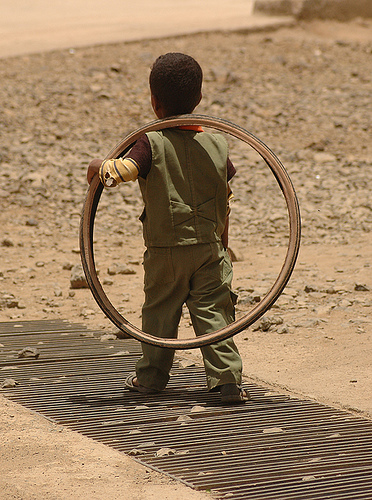

In [10]:
Image.open(get_full_path_to_img(train_images[1]))

### Divide captions for train, test, val

In [11]:
train_captions = {}
val_captions = {}
test_captions = {}

In [12]:
for img in train_images:
    train_captions[img] = captions[img]
    
for img in val_images:
    val_captions[img] = captions[img]
    
for img in test_images:
    test_captions[img] = captions[img]

In [13]:
print(len(train_captions.values()))
print(len(val_captions.values()))
print(len(test_captions.values()))

6000
1000
1000


### Preprocess images

In [14]:
# Could be used later for data augmentation

# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         width_shift_range=0.2, 
#         height_shift_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# def process(X, train=True):
#     if train:
#         return train_datagen.flow(X, batch_size=BATCH_SIZE)
#     else:
#         return test_datagen.flow(X, batch_size=BATCH_SIZE)
    
# im = cv2.imread(get_full_path_to_img(train_images[1]))
# im_procesed = process( np.array([im]), np.array([0]) )

# # print(im_procesed.index_array)

# # for i in im_procesed:
# #     print(i.shape)
# #     plt.imshow(i[0])

In [15]:
def preprocess_input(x):
    x /= 255.
#     x -= 0.5
    x *= 2.
    return x

In [16]:
def preprocess(image_title):
    img = get_numpy_img(image_title)
    x = image.img_to_array(img)
        
    x = np.expand_dims(x, axis=0)    
    x = preprocess_input(x)
    
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


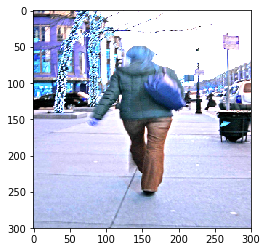

In [17]:
preprocessed_img = np.squeeze(preprocess(train_images[34])) 
preprocessed_img = np.rollaxis(preprocessed_img, 0, 3)

plt.imshow(preprocessed_img)

## InceptionV3 Model

### Cut off the last layer of the keras InceptionV3

In [18]:
inception_model = InceptionV3(weights='imagenet')

In [19]:
from keras.models import Model

# We do not need dense(prediction) layer from InceptionV3 model,
# so remove it and create own instance of the InceptionV3 which output will be 2048 neurons

new_input = inception_model.input
hidden_layer = inception_model.layers[-2].output

model = Model(new_input, hidden_layer)

In [20]:
pre_tmp = model.predict(preprocess(train_images[0]))

In [21]:
pre_tmp.shape

(1, 2048)

###  Encode ...

In [22]:
def encode(image):
    image = preprocess(image)
    enc_tmp = model.predict(image)
    enc_tmp = np.reshape(enc_tmp, enc_tmp.shape[1])
    return enc_tmp

#### Preprocess train/val/test images

In [23]:
encoding_train = {}

for img in tqdm(train_images):
    encoding_train[img] = encode(img)

100%|██████████| 6000/6000 [04:02<00:00, 24.74it/s]


In [24]:
encoding_train[train_images[0]]

array([0.16101134, 0.374247  , 0.24103081, ..., 0.39121163, 0.45048285,
       0.14845225], dtype=float32)

In [25]:
encoding_test = {}

for img in tqdm(test_images):
    encoding_test[img] = encode(img)

100%|██████████| 1000/1000 [00:38<00:00, 25.93it/s]


In [26]:
encoding_test[test_images[0]]

array([0.35276657, 0.53431845, 1.5692801 , ..., 0.5267854 , 1.4482155 ,
       0.09569249], dtype=float32)

In [27]:
encoding_val = {}

for img in tqdm(val_images):
    encoding_val[img] = encode(img)

100%|██████████| 1000/1000 [00:38<00:00, 26.12it/s]


In [28]:
encoding_val[val_images[0]]

array([0.26928285, 0.13009535, 0.11119601, ..., 0.66144824, 0.444611  ,
       0.30700588], dtype=float32)

#### Save proccesed encodings

In [29]:
# Save processed images into the file

with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)
    
with open("encoded_images_train_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)
    
with open("encoded_images_val_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_val, encoded_pickle)

## Preprocess captions

In [68]:
# Append in the start of each caption <start> tag and <end> in the end

captions_extended = {}

for key, val in captions.items():
    for row in val:
        if not(key in captions_extended):
            captions_extended[key] = []
        
        captions_extended[key].append('<start> ' + row + ' <end>')

print(captions_extended[train_images[0]])

['<start> A goalie tries to catch a ball during a soccer game . <end>', '<start> A group of guys playing soccer on a field . <end>', '<start> Footballers are scrambling around the goal as the goal keeper reaches for the ball . <end>', '<start> Four men in green at a soccer goal post trying to score , while 3 men in blue try to prevent it . <end>', '<start> Two soccer teams converge at the goal and the goalie reaches for the ball . <end>']


In [69]:
# Get the number of unique words in captions
c_set = set()
for row in ["".join(x).split(" ") for x in captions_extended.values()]:
    for w in row:
        c_set.add(w)

UNIQUE_WORDS_NUM = len(c_set)

In [70]:
tokenizer =  Tokenizer(num_words=UNIQUE_WORDS_NUM)

print('Fitting tokenizer...')

captions_list = list(captions_extended.values())
captions_list = [sentence.split(" ") for group in captions_list for sentence in group]

tokenizer.fit_on_texts(captions_list)

Fitting tokenizer...


In [71]:
print(tokenizer.word_index['scared'])

3892


In [167]:
tmp = list(captions_extended.values())

print(tmp[0][0])
print(tokenizer.texts_to_sequences([tmp[0][0]]))
# print(tokenizer.texts_to_sequences(tmp[0][0]))

<start> A boy runs in a race while onlookers watch . <end>
[[2093, 1, 17, 75, 5, 1, 159, 37, 676, 227, 678]]


In [88]:
tokenizer.word_index

{'fat': 1940,
 'gas': 2173,
 'welcome': 6031,
 'filed': 6279,
 'stairway': 1498,
 'tourists': 2102,
 'moutnain': 7620,
 'signpost': 6842,
 'partner': 4799,
 'marsh': 2141,
 'paneled': 5022,
 'marches': 3178,
 'tale': 8235,
 'amuseument': 4715,
 'operated': 8094,
 'two-wheeled': 8845,
 'ashen': 7676,
 'parkinglot': 8559,
 'consumer': 6724,
 'yorkshire': 4737,
 'landmark': 8250,
 'toy': 106,
 'half-way': 8836,
 'packers': 5365,
 'frown': 5783,
 'sign': 224,
 'rockstar': 4373,
 'seen': 809,
 'feeds': 2537,
 'middleaged': 8491,
 'anticipates': 8676,
 'euro': 8021,
 'biden': 6075,
 'netted': 5169,
 'pawing': 4807,
 'kid': 274,
 'treefilled': 5926,
 'containing': 2181,
 'entertaining': 7944,
 'tak': 6783,
 'cellphone': 434,
 'joking': 7336,
 'running': 34,
 'between': 359,
 'into': 66,
 'countryside': 1579,
 'afican': 7895,
 'fetch': 955,
 'shaky': 8331,
 'sleeved': 1591,
 'intercept': 4516,
 'government': 7283,
 'croquette': 7128,
 'call': 3082,
 'south': 6179,
 'parade': 555,
 '3': 1385,
 

In [168]:
tokenizer.word_index['a']

1

In [75]:
# combine a pandas dataframe

train_df = pd.DataFrame.from_dict(captions_extended)

In [76]:
train_df.head()

,1000268201_693b08cb0e.jpg,1001773457_577c3a7d70.jpg,1002674143_1b742ab4b8.jpg,1003163366_44323f5815.jpg,1007129816_e794419615.jpg,1007320043_627395c3d8.jpg,1009434119_febe49276a.jpg,1012212859_01547e3f17.jpg,1015118661_980735411b.jpg,1015584366_dfcec3c85a.jpg,...,98377566_e4674d1ebd.jpg,985067019_705fe4a4cc.jpg,987907964_5a06a63609.jpg,989754491_7e53fb4586.jpg,989851184_9ef368e520.jpg,990890291_afc72be141.jpg,99171998_7cc800ceef.jpg,99679241_adc853a5c0.jpg,997338199_7343367d7f.jpg,997722733_0cb5439472.jpg
0,<start> A child in a pink dress is climbing up...,<start> A black dog and a spotted dog are figh...,<start> A little girl covered in paint sits in...,<start> A man lays on a bench while his dog si...,<start> A man in an orange hat starring at som...,<start> A child playing on a rope net . <end>,<start> A black and white dog is running in a ...,"<start> A dog shakes its head near the shore ,...",<start> A boy smiles in front of a stony wall ...,<start> A black dog leaps over a log . <end>,...,<start> Two brown and white dogs lift their ea...,<start> A boy goes down an inflatable slide . ...,<start> one brown and white dog chasing a blac...,<start> A girl in a pool wearing goggles and s...,<start> A black dog has a dumbbell in his mout...,<start> A man does a wheelie on his bicycle on...,<start> A group is sitting around a snowy crev...,<start> A grey bird stands majestically on a b...,<start> A person stands near golden walls . <end>,<start> A man in a pink shirt climbs a rock fa...
1,<start> A girl going into a wooden building . ...,<start> A black dog and a tri-colored dog play...,<start> A little girl is sitting in front of a...,<start> A man lays on the bench to which a whi...,<start> A man wears an orange hat and glasses ...,<start> A little girl climbing on red roping ....,<start> A black and white dog is running throu...,<start> A white dog shakes on the edge of a be...,<start> A little boy is standing on the street...,<start> A grey dog is leaping over a fallen tr...,...,<start> Two little dogs looking out of their c...,<start> A boy in red slides down an inflatable...,<start> The two dogs are running through the g...,<start> A girl in green goggles in a pool with...,<start> A black dog has a dumbbell in his mout...,<start> A man is doing a wheelie on a mountain...,<start> A group of people sit atop a snowy mou...,<start> A large bird stands in the water on th...,<start> a woman behind a scrolled wall is writ...,<start> A man is rock climbing high in the air...
2,<start> A little girl climbing into a wooden p...,<start> A black dog and a white dog with brown...,<start> A small girl in the grass plays with f...,<start> a man sleeping on a bench outside with...,<start> A man with gauges and glasses is weari...,<start> A little girl in pink climbs a rope br...,<start> A Boston terrier is running in the gra...,"<start> Dog with orange ball at feet , stands ...",<start> A young boy runs aross the street . <end>,<start> A large black dog leaps a fallen log ....,...,<start> Two small dogs are in a cage outside ....,<start> A boy is sliding down in a red shirt ....,<start> Two cocker spaniels running through th...,<start> A red haired girl making a peace sign ...,<start> A black dog holding a weight in its mo...,<start> A man on a bicycle is on only the back...,<start> A group of people sit in the snow over...,<start> A tall bird is standing on the sand be...,<start> A woman standing near a decorated wall...,<start> A person in a red shirt climbing up a ...
3,<start> A little girl climbing the stairs to h...,<start> Two dogs of different breeds looking a...,<start> There is a girl with pigtails sitting ...,<start> A shirtless man lies on a park bench w...,<start> A man with glasses is wearing a beer c...,<start> A small child grips onto the red ropes...,<start> A Boston Terrier is running on lush gr...,<start> White dog playing with a red ball on t...,<start> A young child is walking on a stone pa...,<start> A mottled black

# Generator

In [92]:
caption_max_len = 40

In [176]:
train_captions_extended = {}

for img in train_images:
    train_captions_extended[img] = captions_extended[img]

In [192]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []

        c = []
        imgs = []
        for image_title, captions_list in train_captions_extended.items():
            c.append(captions_list[0])
            imgs.append(image_title)


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                
#                 print(text)
                for i in range(len(text.split())-1):
                    count += 1
                    
                    partial = tokenizer.texts_to_sequences([text])[0]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(UNIQUE_WORDS_NUM)
                    
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[tokenizer.word_index[text.split()[i+1].lower()]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count >= batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        
#                         print("BEFORE partial_caps: ", partial_caps)                  
#                         print(sequence.pad_sequences(partial_caps, maxlen=caption_max_len, padding='post'))
                        
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=caption_max_len, padding='post')
#                         print("AFTER partial_caps: ", partial_caps)

                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

# Create the model

In [91]:
embedding_size = 300

In [96]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(caption_max_len)
    ])

In [98]:
caption_model = Sequential([
        Embedding(UNIQUE_WORDS_NUM, embedding_size, input_length=caption_max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [140]:
caption_model.output

<tf.Tensor 'time_distributed_1/Reshape_1:0' shape=(?, 40, 300) dtype=float32>

In [198]:
# a = Sequential([
#     concatenate([image_model.output, caption_model.output], axis=1)
# ])


image_in = Input(shape=(2048,), name="image_model_input")
caption_in = Input(shape=(caption_max_len,), name="caption_model_input")

merged = concatenate([image_model(image_in), caption_model(caption_in)], axis=1)
latent = Bidirectional(LSTM(256, return_sequences=False))(merged)
out = Dense(UNIQUE_WORDS_NUM, activation='softmax')(latent)

final_model = Model([image_in, caption_in], out)

In [199]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [200]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_model_input (InputLayer)  (None, 2048)         0                                            
__________________________________________________________________________________________________
caption_model_input (InputLayer (None, 40)           0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 40, 300)      614700      image_model_input[0][0]          
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 40, 300)      3537368     caption_model_input[0][0]        
__________________________________________________________________________________________________
concatenat

In [152]:
### Train!!!

In [201]:
# 2759089516_cbb993cb92.jpg
encoding_train

{'2169951750_495820a215.jpg': array([0.3371526 , 0.342325  , 0.12034915, ..., 1.1500459 , 0.382743  ,
        0.1951198 ], dtype=float32),
 '2188192752_09d9fc5431.jpg': array([0.40961897, 0.16438964, 0.6190834 , ..., 0.20325537, 0.8979852 ,
        0.20661941], dtype=float32),
 '2113530024_5bc6a90e42.jpg': array([0.16101134, 0.374247  , 0.24103081, ..., 0.39121163, 0.45048285,
        0.14845225], dtype=float32),
 '2500354186_0836309cc9.jpg': array([0.16912931, 0.35260555, 0.10164326, ..., 0.1998112 , 0.4940226 ,
        0.        ], dtype=float32),
 '72964268_d532bb8ec7.jpg': array([0.09074529, 0.287202  , 0.50446165, ..., 1.135828  , 0.78688884,
        0.3589258 ], dtype=float32),
 '3598447435_f66cd10bd6.jpg': array([0.09462522, 0.3420554 , 0.5332509 , ..., 0.4633505 , 1.028255  ,
        0.20862193], dtype=float32),
 '1247181182_35cabd76f3.jpg': array([0.23487154, 0.02307176, 0.5671986 , ..., 0.8079382 , 1.2911317 ,
        0.291508  ], dtype=float32),
 '3521201948_9049197f20.jpg':

In [225]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=10000, nb_epoch=1, verbose=1)

/home/andrew/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/home/andrew/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, steps_per_epoch=10000, epochs=1)`
  """Entry point for launching an IPython kernel.


Epoch 1/1
10000/10000 [==============================] - 2516s 252ms/step - loss: 3.4802 - acc: 0.1379


## Prediction function

In [220]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
#         par_caps = [word2idx[i] for i in start_word]
        par_caps = tokenizer.texts_to_sequences([start_word])[0]

        par_caps = sequence.pad_sequences([par_caps], maxlen=caption_max_len, padding='post')
        
        
        e = encoding_train[image]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        
        word_pred = tokenizer.index_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > caption_max_len:
            break
            
    return ' '.join(start_word[1:-1])

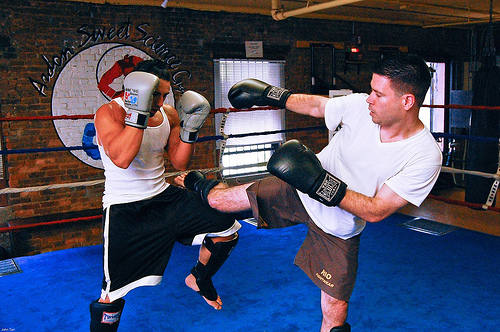

In [262]:
# try_image = test_images[0]
try_image = train_images[27]
Image.open(get_full_path_to_img(try_image))

In [263]:
predict_captions(try_image)

'. . . . a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a'